Loading training dataset...
Rounding threshold column to 1 decimal place...
Training data shape: (1313, 18)

Extracting start and end accuracies for each model...

Extracted accuracy ranges for 13 models. Skipped 0 models.

Sample of accuracy ranges:
   model_id  acc_0  acc_10  acc_drop
0         2  0.988   0.501     0.487
1         3  0.915   0.500     0.415
2         4  0.996   0.500     0.496
3         6  0.977   0.734     0.243
4         7  0.891   0.500     0.391


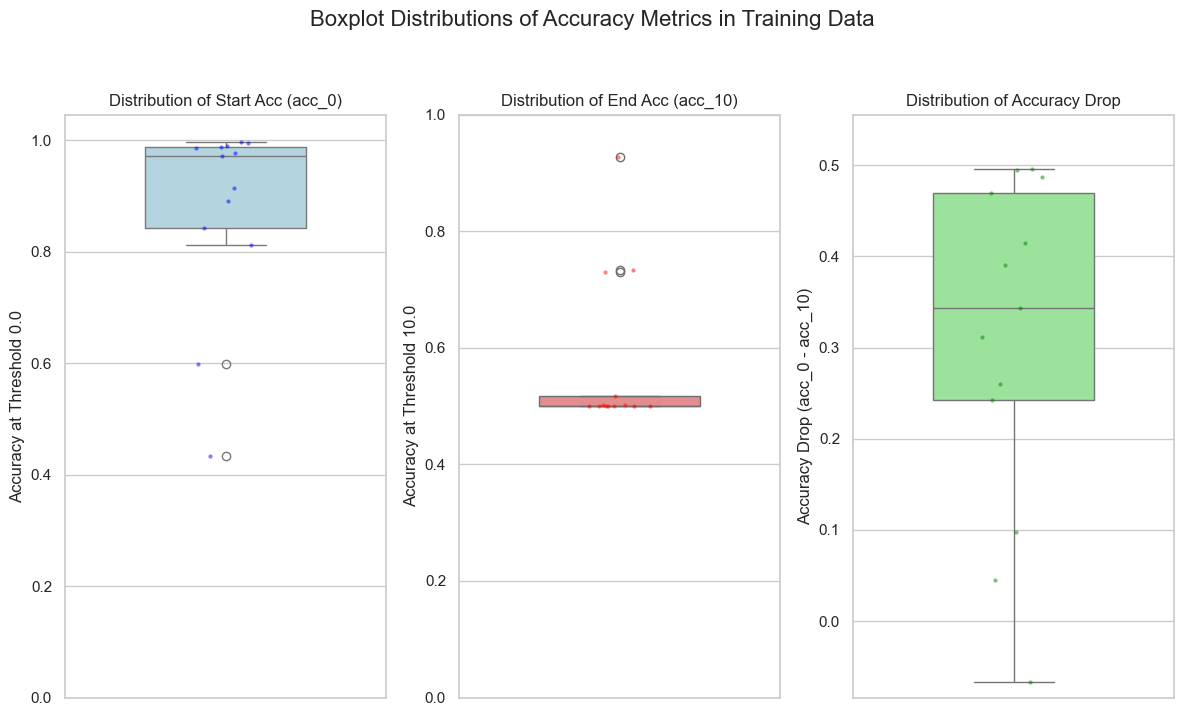

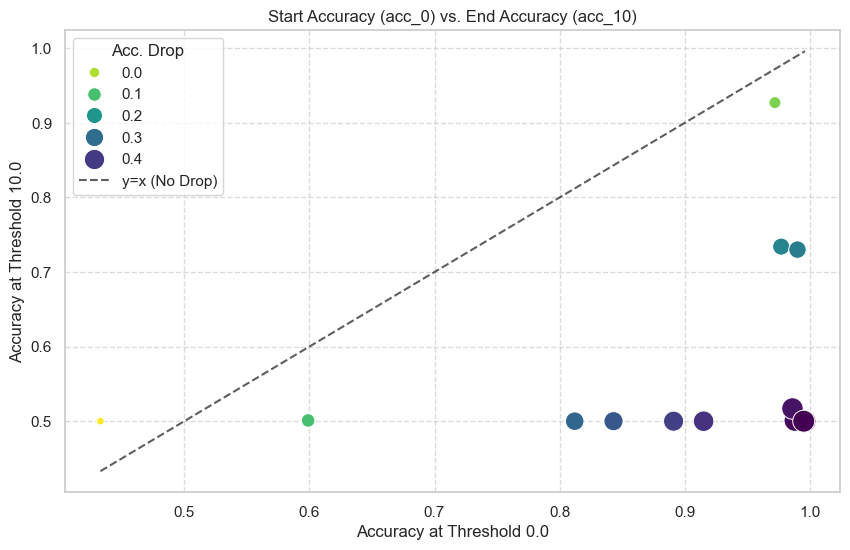


Plotting individual accuracy ranges for 13 models...


/var/folders/qs/79b2v6y56fn4w0bk9glvt79h0000gn/T/ipykernel_60836/251467186.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm') # Or 'viridis', 'plasma', etc.


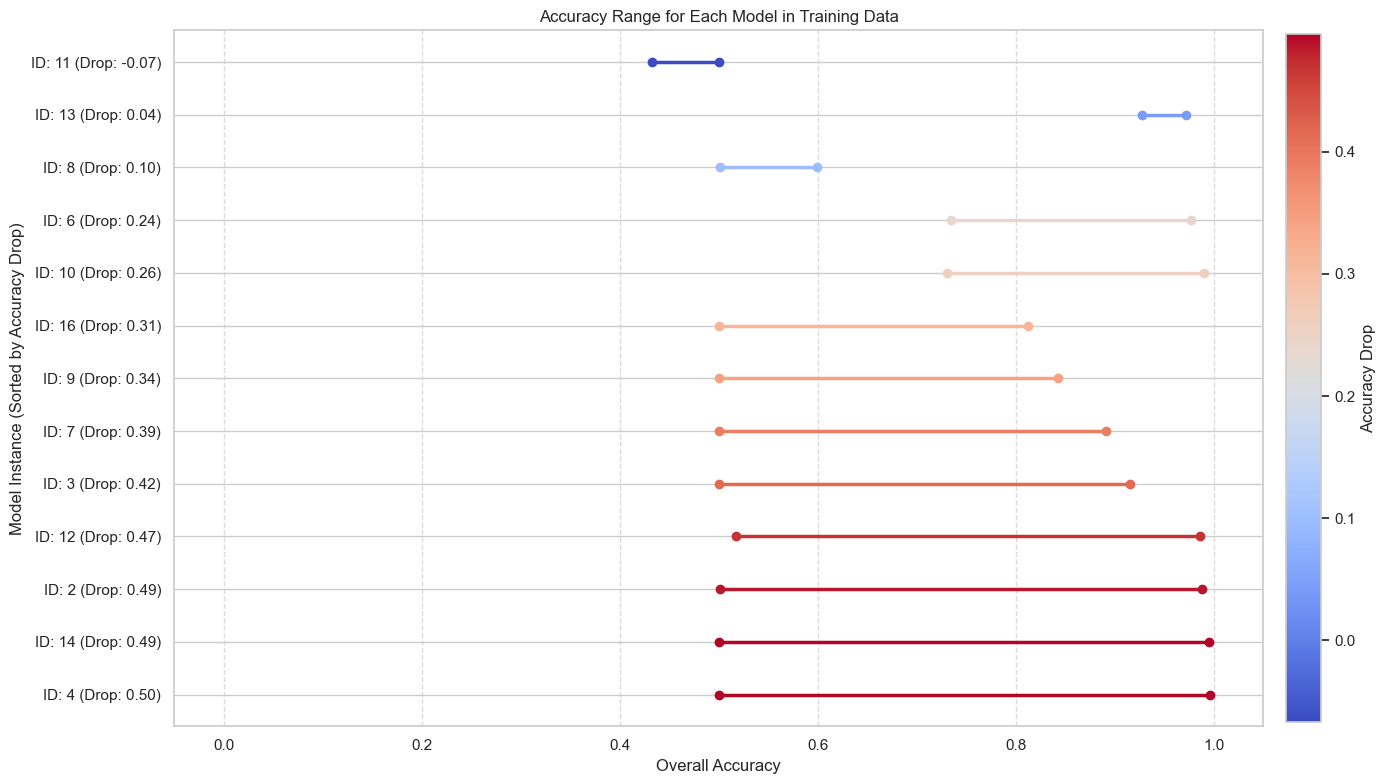


Summary statistics for accuracy ranges:
           acc_0     acc_10   acc_drop
count  13.000000  13.000000  13.000000
mean    0.876692   0.570000   0.306692
std     0.174528   0.137409   0.184448
min     0.433000   0.500000  -0.067000
25%     0.843000   0.500000   0.243000
50%     0.972000   0.500000   0.343000
75%     0.988000   0.517000   0.469000
max     0.996000   0.927000   0.496000

Data analysis script finished.


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns # For nicer aesthetics and boxplots

# --- Configuration ---
DATASET_PATH = Path("data_split") # Path to the folder with pre-split CSVs
TARGET_COL = 'overall_accuracy'

# --- 1. Load Training Dataset ---
print("Loading training dataset...")
try:
    train_df_raw = pd.read_csv(DATASET_PATH / "train_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure '{DATASET_PATH / 'train_dataset.csv'}' exists.")
    print(f"Please run the `prepare_datasets.py` script first.")
    exit()

# Round the threshold column
print("Rounding threshold column to 1 decimal place...")
train_df = train_df_raw.copy()
train_df['threshold'] = train_df['threshold'].round(1)

print(f"Training data shape: {train_df.shape}")
if train_df.empty:
    print("Training data is empty. Cannot perform analysis.")
    exit()

# --- 2. Extract Start (acc_0) and End (acc_10) Accuracies for Each Model ---
print("\nExtracting start and end accuracies for each model...")
model_accuracy_ranges = []
skipped_models = 0

for model_id, group in train_df.groupby('model_id'):
    group = group.sort_values(by='threshold')
    
    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    acc_at_10_series = group[group['threshold'] == 10.0][TARGET_COL]

    if acc_at_0_series.empty or acc_at_10_series.empty:
        print(f"Warning: Skipping model_id {model_id} due to missing acc_0 or acc_10 data.")
        skipped_models += 1
        continue
        
    acc_0 = acc_at_0_series.iloc[0]
    acc_10 = acc_at_10_series.iloc[0]
    
    model_accuracy_ranges.append({
        'model_id': model_id,
        'acc_0': acc_0,
        'acc_10': acc_10,
        'acc_drop': acc_0 - acc_10
    })

if not model_accuracy_ranges:
    print("No models with complete start and end accuracy data found. Cannot perform analysis.")
    exit()

ranges_df = pd.DataFrame(model_accuracy_ranges)
print(f"\nExtracted accuracy ranges for {len(ranges_df)} models. Skipped {skipped_models} models.")
print("\nSample of accuracy ranges:")
print(ranges_df.head())

# --- 3. Data Analysis and Visualizations ---
sns.set_theme(style="whitegrid") # Apply a nice theme

# --- 3a. Boxplots for acc_0, acc_10, and acc_drop ---
plt.figure(figsize=(12, 7))

plt.subplot(1, 3, 1)
sns.boxplot(y=ranges_df['acc_0'], color="lightblue", width=0.5)
sns.stripplot(y=ranges_df['acc_0'], color="blue", alpha=0.5, jitter=True, size=3) # Overlay individual points
plt.title('Distribution of Start Acc (acc_0)')
plt.ylabel('Accuracy at Threshold 0.0')
plt.ylim(min(0, ranges_df['acc_0'].min() - 0.05) , max(1, ranges_df['acc_0'].max() + 0.05))


plt.subplot(1, 3, 2)
sns.boxplot(y=ranges_df['acc_10'], color="lightcoral", width=0.5)
sns.stripplot(y=ranges_df['acc_10'], color="red", alpha=0.5, jitter=True, size=3)
plt.title('Distribution of End Acc (acc_10)')
plt.ylabel('Accuracy at Threshold 10.0')
plt.ylim(min(0, ranges_df['acc_10'].min() - 0.05) , max(1, ranges_df['acc_10'].max() + 0.05))

plt.subplot(1, 3, 3)
sns.boxplot(y=ranges_df['acc_drop'], color="lightgreen", width=0.5)
sns.stripplot(y=ranges_df['acc_drop'], color="green", alpha=0.5, jitter=True, size=3)
plt.title('Distribution of Accuracy Drop')
plt.ylabel('Accuracy Drop (acc_0 - acc_10)')
# Dynamic y-lim for drop, as it can be negative if acc_10 > acc_0
min_drop = ranges_df['acc_drop'].min()
max_drop = ranges_df['acc_drop'].max()
plt.ylim(min_drop - abs(min_drop*0.1) - 0.01, max_drop + abs(max_drop*0.1) + 0.01)


plt.suptitle('Boxplot Distributions of Accuracy Metrics in Training Data', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
plt.show()


# --- 3b. Scatter Plot of Start vs. End Accuracy (Kept as it's informative) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ranges_df, x='acc_0', y='acc_10', hue='acc_drop', size='acc_drop', sizes=(30, 250), palette='viridis_r', legend="auto")
plt.title('Start Accuracy (acc_0) vs. End Accuracy (acc_10)')
plt.xlabel('Accuracy at Threshold 0.0')
plt.ylabel('Accuracy at Threshold 10.0')
plt.plot([ranges_df['acc_0'].min(), ranges_df['acc_0'].max()], [ranges_df['acc_0'].min(), ranges_df['acc_0'].max()], 'k--', alpha=0.7, label='y=x (No Drop)')
plt.legend(title='Acc. Drop')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- 3c. Enhanced Individual Model Accuracy Ranges Plot (Line Range Plot) ---
# Sort by acc_drop for a potentially interesting visual, or by acc_0
ranges_df_sorted = ranges_df.sort_values(by='acc_drop', ascending=False).reset_index(drop=True)
num_models_to_plot = len(ranges_df_sorted)

if num_models_to_plot == 0:
    print("No models to plot for individual ranges.")
else:
    print(f"\nPlotting individual accuracy ranges for {num_models_to_plot} models...")
    
    max_models_for_direct_plot = 50 
    if num_models_to_plot > max_models_for_direct_plot:
        print(f"Warning: Too many models ({num_models_to_plot}). Plotting a representative sample of {max_models_for_direct_plot}.")
        plot_df = ranges_df_sorted.sample(n=max_models_for_direct_plot, random_state=42).sort_values(by='acc_drop', ascending=False).reset_index(drop=True)
    else:
        plot_df = ranges_df_sorted

    fig, ax = plt.subplots(figsize=(14, max(8, 0.35 * len(plot_df)))) # Get fig and ax
    
    # Create a colormap for the lines based on acc_drop
    norm = plt.Normalize(plot_df['acc_drop'].min(), plot_df['acc_drop'].max())
    cmap = plt.cm.get_cmap('coolwarm') # Or 'viridis', 'plasma', etc.

    for index, row in plot_df.iterrows():
        line_color = cmap(norm(row['acc_drop']))
        # Plot on the specific axes 'ax'
        ax.plot([row['acc_0'], row['acc_10']], [index, index], marker='o', markersize=6, linestyle='-', linewidth=2.5, color=line_color)

    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels([f"ID: {mid} (Drop: {drop:.2f})" for mid, drop in zip(plot_df['model_id'], plot_df['acc_drop'])])
    ax.set_xlabel('Overall Accuracy')
    ax.set_ylabel('Model Instance (Sorted by Accuracy Drop)')
    ax.set_title('Accuracy Range for Each Model in Training Data')
    ax.set_xlim(-0.05, 1.05) 
    ax.grid(True, linestyle='--', alpha=0.7, axis='x')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    # Explicitly pass the axes to colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02) 
    cbar.set_label('Accuracy Drop')
        
    plt.tight_layout()
    plt.show()

# --- 4. Summary Statistics ---
print("\nSummary statistics for accuracy ranges:")
print(ranges_df[['acc_0', 'acc_10', 'acc_drop']].describe())

print("\nData analysis script finished.")